## Final Project Submission

Please fill out:
* Student name: Andrew Levinton
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Ahbineet Kulkarni
* Blog post URL:


## Statsmodels debug
- This is because statsmodels was having version issues. this is a workaround
- The code below re-publishes the existing (but private) _centered function as a public attribute to the module already imported in RAM.

In [41]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

## Import necessary libraries

In [42]:
# raw data handling
import pandas as pd
import numpy as np
import datetime as dt

# data visualiztion
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pywaffle import Waffle
import squarify

plt.style.use('fivethirtyeight')

# regression modeling
import statsmodels.api as sm
from statsmodels.formula.api import ols

# model validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings # weird sns.distplot() warnings
warnings.filterwarnings("ignore")

import squarify

plt.style.use('fivethirtyeight')

In [43]:
cd data

[WinError 2] The system cannot find the file specified: 'data'
C:\Users\alevi\Documents\Flatiron\dsc-data-science-env-config\Course_Folder\Phase_2\Phase_2_Project\dsc-phase-2-project-v2-5\data


## Read in dataset

In [44]:
df = pd.read_csv('kc_house_data.csv')
len(df)

30155

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

#### Simple Linear Regression on select features
Assumption check:
- Is it linear?
- Is it normal?
    - histogram
    - QQ-plot
- Is it homoscedastic?

In [46]:
df = df.dropna()

In [47]:
len(df)

30111

## Data Preparation

In [48]:
# Changing grade to a float
df['grade'] = df['grade'].apply(lambda x: float(x.split(' ')[0]))

# replaces condition objects with numerics based on data dict.
condition_dict = {'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
df.condition.replace(to_replace=condition_dict,inplace=True)

# replace yr_built NaNs with numeric 0
df.yr_renovated.replace(to_replace=np.nan,value=0,inplace=True)

# convert waterfront into numeric boolean
waterfront_bool_dict = {'YES':1,'NO':0,np.nan:0}
df.waterfront.replace(to_replace=waterfront_bool_dict,inplace=True)

# convert view from string into categorical ordinal
view_dict = {np.nan:0,'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}
df.view.replace(to_replace=view_dict,inplace=True)

# convert dates into ordinals, extrapolate month from date into new column. 
df.date = pd.to_datetime(df['date']) # convert date string into datetime object 
df['sale_month'] = df['date'].dt.month # grabbing month from date into new column
df['sale_year'] = df['date'].dt.year # grabbing year from date into new column
df.date = df['date'].map(dt.datetime.toordinal) # convert original date to ordinal
df.rename({'date':'sale_date'},axis=1,inplace=True) # rename date to 'sale_date' for readability 

In [49]:
df['address'][0]

'2102 Southeast 21st Court, Renton, Washington 98055, United States'

### Grabbing City

In [50]:
df['city'] = df['address'].apply(lambda x: x.split(',')[1])

### Grabbing Zipcode

In [51]:
df['zipcode'] = df['address'].apply(lambda x: x.split(',')[2].split(' ')[-1])
df['zipcode'] = df['zipcode'].apply(lambda x: '97210' if 'Portland' in x\
                                    else '91730' if 'Cucamonga' in x\
                                    else '29582' if 'Beach' in x\
                                    else '34698' if 'Dunedin' in x\
                                    else '43210' if 'Columbus' in x\
                                   else '98126' if 'Seattle' in x\
                                   else '54002' if 'Baldwin'in x\
                                   else '78257' if 'Antonio' in x\
                                   else '02134' if 'Allston'in x\
                                   else '07031' if 'Arlington' in x\
                                   else '73118' if 'City' in x\
                                   else '94122' if 'Francisco' in x\
                                   else '02852' if 'Kingstown' in x\
                                   else '85705' if 'Tucson' in x\
                                   else x)

In [52]:
df[~df['zipcode'].str.startswith('98')]['zipcode']

12       68106
53       08360
62       62859
159      07087
172      11704
         ...  
30029    07031
30044    53142
30116    55901
30129    08054
30144    33147
Name: zipcode, Length: 911, dtype: object

In [53]:
df['address'][29515]

'Avenue, 1710 Belle Isle Blvd, Oklahoma City, Oklahoma 73118, United States'

In [54]:
non_zips = ['Portland','Cucamonga','Beach','Dunedin','Columbus','Seattle','Baldwin','Antonio','Allston','Kingstown'\
           'Tucson','Arlington','City','Francisco']

bad_zips = df[df['zipcode'].isin(non_zips)]
# bad_zips['zipcode'].value_counts()

bad_zips['zipcode']

Series([], Name: zipcode, dtype: object)

### One Hot Encoding Categorical Data

In [61]:
df['floors'] = df['floors'].astype(str)
floor_dummies = pd.get_dummies(df['floors'],prefix='floors',drop_first=True)

df['condition'] = df['condition'].astype(str)
cond_dummies =  pd.get_dummies(df['condition'],prefix='cond',drop_first=True)

df['grade'] = df['grade'].astype(str)
grade_dummies = pd.get_dummies(df['grade'],prefix='grade',drop_first=True)


In [62]:
df.columns

Index(['id', 'sale_date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'sale_month', 'sale_year',
       'city', 'zipcode'],
      dtype='object')

## Model #1

In [66]:
X = df[['sqft_living','bathrooms','sqft_above','sqft_garage','sqft_basement','view','bedrooms']]
model_data = pd.concat([X,floor_dummies,cond_dummies,grade_dummies],axis=1)
model_data
y = df['price']

In [68]:
model = sm.OLS(y, sm.add_constant(X))
results_baseline = model.fit()

print(results_baseline.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     3140.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:32:00   Log-Likelihood:            -4.4718e+05
No. Observations:               30111   AIC:                         8.944e+05
Df Residuals:                   30103   BIC:                         8.944e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.106e+05   1.52e+04      7.284

In [69]:
model = sm.OLS(y, sm.add_constant(model_data))
results_baseline = model.fit()

print(results_baseline.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     1063.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:38:37   Log-Likelihood:            -4.4508e+05
No. Observations:               30111   AIC:                         8.902e+05
Df Residuals:                   30082   BIC:                         8.905e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.131e+06   8.99e+04     12.576

## Eliminating Outliers

In [863]:
std_thresh = df.price.std()*3 # value of the third central moment of the target variable
df = df.loc[abs(df['price']) <= std_thresh] # slicing all data within the defined range

# # assign X and y variables to the appropriate dataframes/series
# y = outlier_eliminated_df.price
# X_outliers_eliminated = outlier_eliminated_df.drop('price',axis=1)

In [864]:
len(df)

28897

In [865]:
df.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.602011
grade            0.576579
sqft_above       0.517397
bathrooms        0.462439
bedrooms         0.332591
sqft_patio       0.264555
sqft_garage      0.259119
view             0.216711
sqft_basement    0.212435
floors           0.206770
sale_year        0.095691
yr_built         0.090713
sale_date        0.087849
lat              0.082877
sqft_lot         0.079134
sale_month       0.073613
yr_renovated     0.064861
waterfront       0.041413
long             0.027950
condition        0.026328
id               0.011473
Name: price, dtype: float64

In [866]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28897 entries, 0 to 30154
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             28897 non-null  int64  
 1   sale_date      28897 non-null  int64  
 2   price          28897 non-null  float64
 3   bedrooms       28897 non-null  int64  
 4   bathrooms      28897 non-null  float64
 5   sqft_living    28897 non-null  int64  
 6   sqft_lot       28897 non-null  int64  
 7   floors         28897 non-null  float64
 8   waterfront     28897 non-null  int64  
 9   greenbelt      28897 non-null  object 
 10  nuisance       28897 non-null  object 
 11  view           28897 non-null  int64  
 12  condition      28897 non-null  int64  
 13  grade          28897 non-null  float64
 14  heat_source    28897 non-null  object 
 15  sewer_system   28897 non-null  object 
 16  sqft_above     28897 non-null  int64  
 17  sqft_basement  28897 non-null  int64  
 18  sqft_g

In [867]:
df['address'].head()

0    2102 Southeast 21st Court, Renton, Washington ...
1    11231 Greenwood Avenue North, Seattle, Washing...
2    8504 South 113th Street, Seattle, Washington 9...
3    4079 Letitia Avenue South, Seattle, Washington...
4    2193 Northwest Talus Drive, Issaquah, Washingt...
Name: address, dtype: object

## Print columns to begin search for predictors

In [869]:
df.columns

Index(['id', 'sale_date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'sale_month', 'sale_year',
       'city', 'zipcode', 'City'],
      dtype='object')

## Check for correlations vs price for numerical variables

In [870]:
df.corr().sort_values('price',ascending=False)['price'].abs()

price            1.000000
sqft_living      0.602011
grade            0.576579
sqft_above       0.517397
bathrooms        0.462439
bedrooms         0.332591
sqft_patio       0.264555
sqft_garage      0.259119
view             0.216711
sqft_basement    0.212435
floors           0.206770
sale_year        0.095691
yr_built         0.090713
sale_date        0.087849
lat              0.082877
sqft_lot         0.079134
yr_renovated     0.064861
waterfront       0.041413
condition        0.026328
id               0.011473
long             0.027950
sale_month       0.073613
Name: price, dtype: float64

## Looking at log transformations for the price.

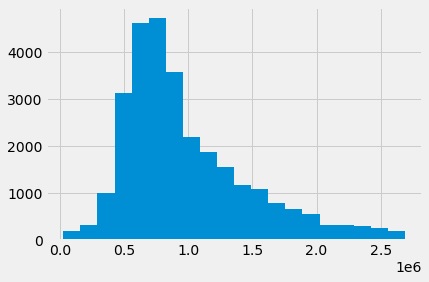

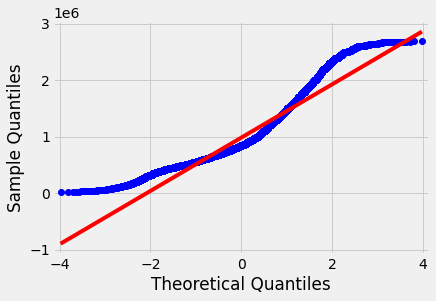

In [871]:
df['price'].hist(bins=20);

sm.graphics.qqplot(df['price'],line='r');

As shown by the histogram of the price, we have a distribution that is heavily skewed right. The QQplot shows that the price follows an exponential pattern.

## Using log transformation to normally distribute the price data

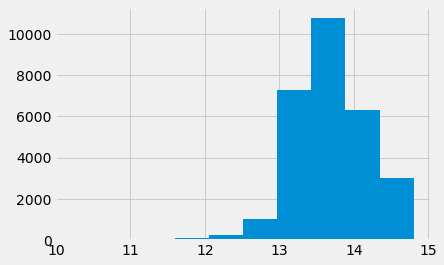

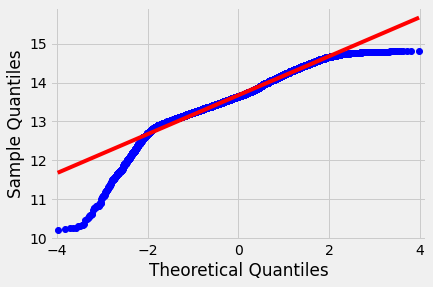

In [872]:
df['price_log'] = np.log(df['price'])

df['price_log'].hist();
sm.qqplot(df['price_log'], line='r');

### Issue above is the data shows linearization everywhere but both tails of the data. Catching the lower tail will be the goal for the next test of transformation. For this, we will try a root transformation. 

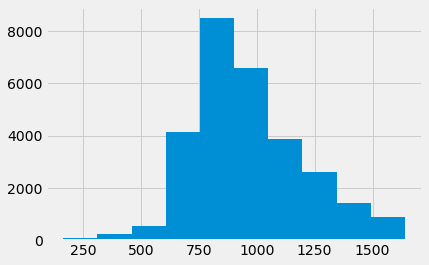

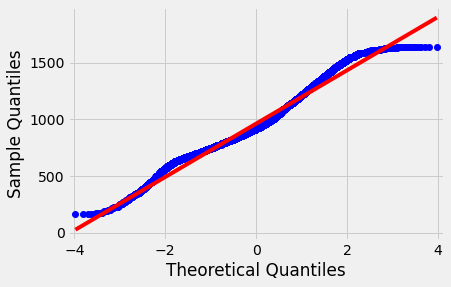

In [873]:
df['price_sqrt'] = df['price'] ** 0.5
df['price_sqrt'].hist();
sm.qqplot(df['price_sqrt'], line='r');

In [874]:
y_sqrt = df['price_sqrt']

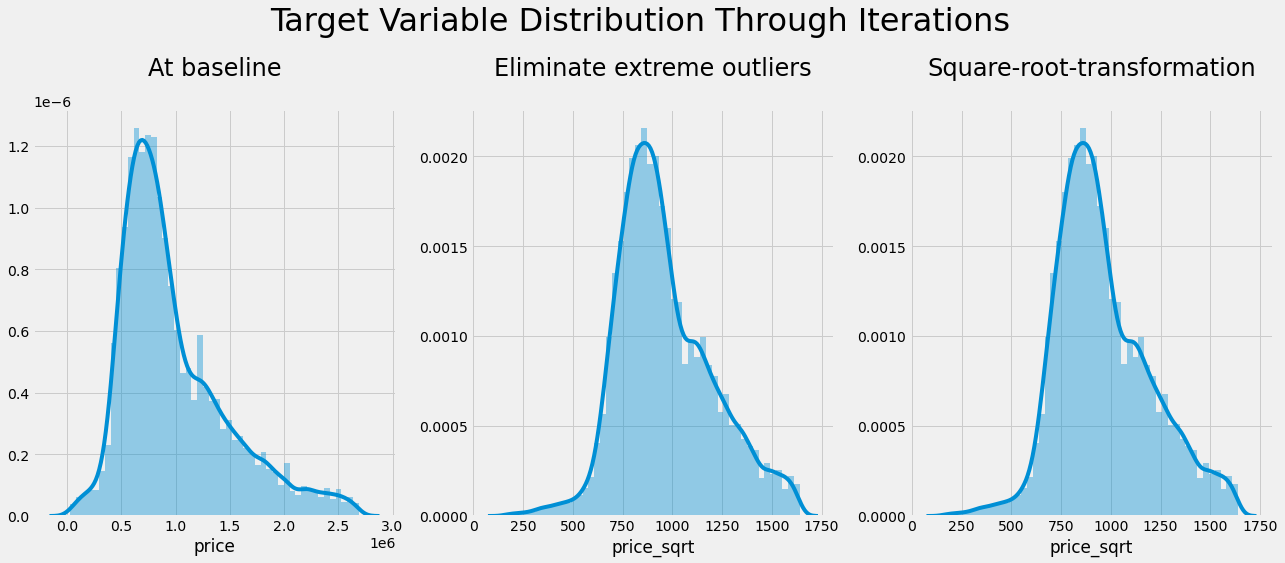

In [875]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

og = sns.distplot(df['price'],ax=ax1).set_title('At baseline\n',fontsize=24)
ot = sns.distplot(y,ax=ax2).set_title('Eliminate extreme outliers\n',fontsize=24)
lo = sns.distplot(y_sqrt,ax=ax3).set_title('Square-root-transformation\n',fontsize=24)

ax1.set_ylabel("")
ax2.set_ylabel("")
ax3.set_ylabel("")


plt.gcf().set_size_inches(18, 8)
plt.suptitle("Target Variable Distribution Through Iterations",fontsize=32)
fig.tight_layout()
plt.show()

## Now checking correlation of numerical values vs the transformed price

In [876]:
df = df.drop(['price_log'],axis='columns')

In [877]:
df.corr()['price_sqrt'].abs().sort_values(ascending=False)

price_sqrt       1.000000
price            0.987192
sqft_living      0.591597
grade            0.574675
sqft_above       0.505529
bathrooms        0.465479
bedrooms         0.332801
sqft_patio       0.262311
sqft_garage      0.254652
sqft_basement    0.216284
floors           0.216042
view             0.207571
yr_built         0.096788
sale_year        0.095845
sale_date        0.087454
lat              0.079176
sqft_lot         0.075319
sale_month       0.074205
yr_renovated     0.060367
waterfront       0.037779
condition        0.028102
long             0.022053
id               0.008427
Name: price_sqrt, dtype: float64

Not much changes in terms of the correlations or the variables in order of correlation. We will look at the sqft_living aka Square footage of living space in the home as our first interesting variable based on the highest correlation. 

## Checking distribution of predictor

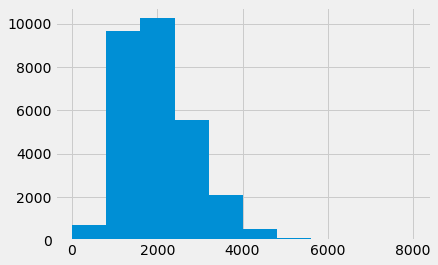

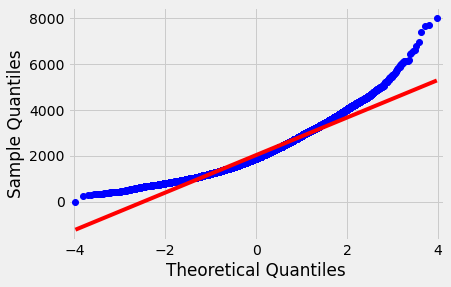

In [878]:
df['sqft_living'].hist();
sm.qqplot(df['sqft_living'], line='r');

Data is clearly skewed right and follows an exponential pattern similar to price. For this, we will use a logarithmic transformation.

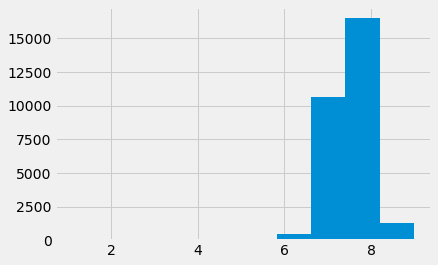

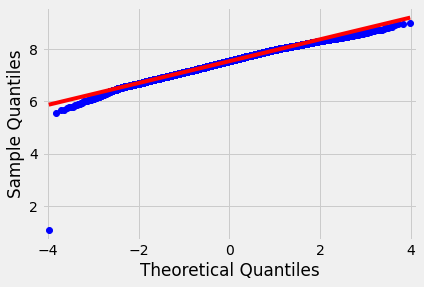

In [879]:
df['sqft_living_log'] = np.log(df['sqft_living'])
df['sqft_living_log'].hist();
sm.qqplot(df['sqft_living_log'], line='r');

Sqft_living now shows an almost perfectly linear qqplot with the logarithmic transformation.

Data appears to be more normally distributed and shows better results on the QQplot.

### Trying out a root transformation to see if there is any improvement. 

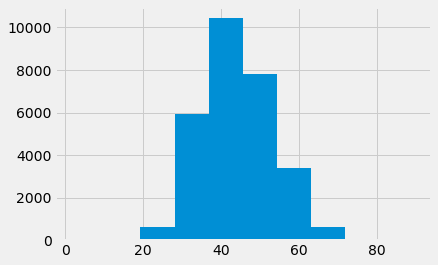

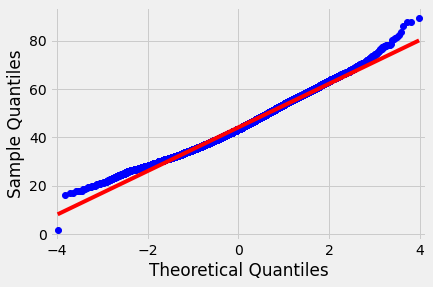

In [880]:
df['sqft_living_sqrt'] = df['sqft_living']**0.5
df['sqft_living_sqrt'].hist();
sm.qqplot(df['sqft_living_sqrt'], line='r');

Square root transformation appears to be improving, so we will use it over the log transformation. 

## Building Preliminary model using the transformed sqft_living variable

In [881]:
X_baseline = df['sqft_living_sqrt']
y = df['price_sqrt']

model = sm.OLS(y, sm.add_constant(X_baseline))
results_baseline = model.fit()

In [882]:
baseline_resid = results_baseline.resid

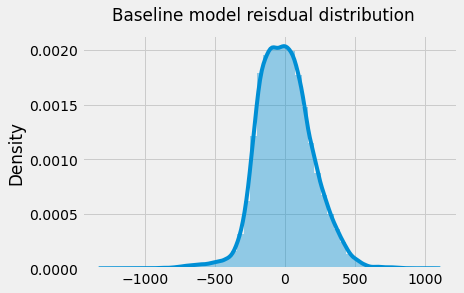

In [883]:
sns.distplot(baseline_resid)
plt.suptitle("Baseline model reisdual distribution")
plt.show()

In [884]:
print(results_baseline.summary())

                            OLS Regression Results                            
Dep. Variable:             price_sqrt   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                 1.517e+04
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:04:13   Log-Likelihood:            -1.9310e+05
No. Observations:               28897   AIC:                         3.862e+05
Df Residuals:                   28895   BIC:                         3.862e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              282.9228      5.632  

- Preliminary model explains approximately 34.4% of the data according the the adjusted r-squared statistic. 
- sqft_living_log is a statistically significant variable as it shows a p-value under the 0.05 parameter

## Adding in new variables

Checking the correlations again to search for more numerical variables

In [885]:
df.corr()['price'].abs().sort_values(ascending=False)

price               1.000000
price_sqrt          0.987192
sqft_living         0.602011
sqft_living_sqrt    0.591360
grade               0.576579
sqft_living_log     0.565793
sqft_above          0.517397
bathrooms           0.462439
bedrooms            0.332591
sqft_patio          0.264555
sqft_garage         0.259119
view                0.216711
sqft_basement       0.212435
floors              0.206770
sale_year           0.095691
yr_built            0.090713
sale_date           0.087849
lat                 0.082877
sqft_lot            0.079134
sale_month          0.073613
yr_renovated        0.064861
waterfront          0.041413
long                0.027950
condition           0.026328
id                  0.011473
Name: price, dtype: float64

### Next variable to try will be the grade as it is on the next highest list for correlation
- Model will now have features consisting of the sqft_living_sqrt variable and the grade against the same dependent variable.
- This will be known as X_NEW to avoid overlapping notation issues.
- Similarly, NEW_model and NEW_results will be the new defined names with the addition of the grade.

In [886]:
df['grade'].value_counts()

7.0     11643
8.0      9288
9.0      3546
6.0      2829
10.0      970
5.0       381
11.0      164
4.0        45
12.0       20
3.0         9
13.0        1
2.0         1
Name: grade, dtype: int64

In [887]:
X_NEW = df[['sqft_living_sqrt','grade']]
y = df['price_sqrt']

NEW_model = sm.OLS(y, sm.add_constant(X_NEW))
NEW_results = NEW_model.fit()
print(NEW_results.summary())

                            OLS Regression Results                            
Dep. Variable:             price_sqrt   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     9824.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:04:15   Log-Likelihood:            -1.9170e+05
No. Observations:               28897   AIC:                         3.834e+05
Df Residuals:                   28894   BIC:                         3.834e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -36.1378      7.965  

In [888]:
r_squared_increase = str(round((NEW_results.rsquared - results_baseline.rsquared) * 100, 1)) + '%'
r_squared_increase

'6.1%'

 - NEW model explains approximately 40.3% of the data according the the adjusted r-squared statistic.
 - sqft_living_sqrt is a statistically significant variable as it shows a p-value under the 0.05 parameter
 - grade is a statistically significant variable as it shows a p-value under the 0.05 parameter
 - Addition of the grade as an independent variable increased the model adj. r-squared by 6%

## The next numerical variable to look at is the sqft_above aka Square footage of house apart from basement. 
- All new names will be repeated as we are adding in new numerical variables to see if they improve the model. 
- First we will look at the distribution of the sqft_above. 

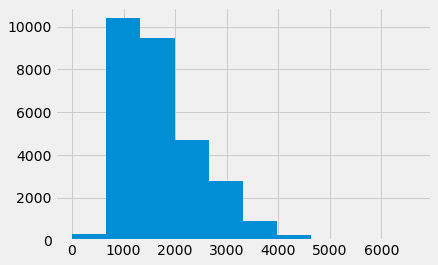

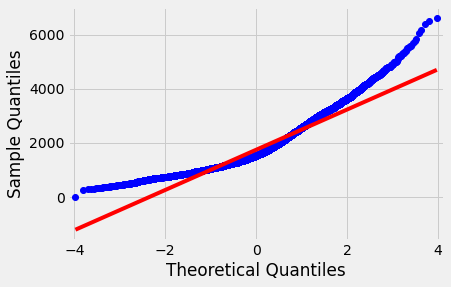

In [889]:
df['sqft_above'].hist();
sm.qqplot(df['sqft_above'], line='r');

### Similar to the sqft_living variable, data appears skewed left and should be transformed before being added to the model. 
- First "try" will be a log transformation, followed again by a root transformation. 

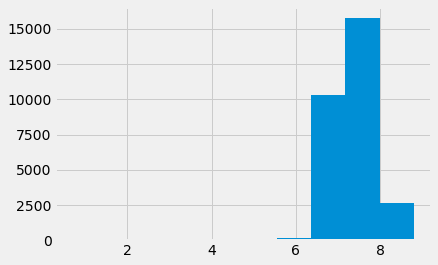

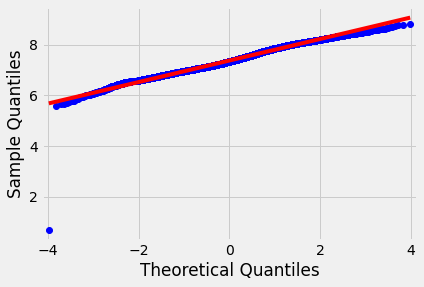

In [890]:
df['sqft_above_log'] = np.log(df['sqft_above'])

df['sqft_above_log'].hist();
sm.qqplot(df['sqft_above_log'], line='r');

Similarly as before with the sqft_living variable, the log transformation appears to be normally distributed now. Time to add the variable to the model to see if it improves. 

In [891]:
X_NEW = df[['sqft_living_sqrt','grade', 'sqft_above_log']]
y = df['price_sqrt']

NEW_model = sm.OLS(y, sm.add_constant(X_NEW))
NEW_results = NEW_model.fit()
print(NEW_results.summary())

                            OLS Regression Results                            
Dep. Variable:             price_sqrt   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     6688.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:04:19   Log-Likelihood:            -1.9158e+05
No. Observations:               28897   AIC:                         3.832e+05
Df Residuals:                   28893   BIC:                         3.832e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              385.1526     27.931  

No meaningful change has been made to the model with the sqft_above variable being added, so it will be left out. Time to look at the other numerical variables to see if any of them can possibly be used to add to the model itself. 

In [937]:
numerical_candidates = df[['sqft_living','grade','sqft_above','bathrooms','sqft_patio','bedrooms',\
                           'sqft_garage','sqft_basement']]

y = df['price_sqrt']

numerical_candidates_model = sm.OLS(y, sm.add_constant(numerical_candidates))
numerical_candidates_results = numerical_candidates_model.fit()
print(numerical_candidates_results.summary())

                            OLS Regression Results                            
Dep. Variable:             price_sqrt   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     2693.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:55:10   Log-Likelihood:            -1.9115e+05
No. Observations:               28897   AIC:                         3.823e+05
Df Residuals:                   28888   BIC:                         3.824e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           144.3210      9.797     14.731

Since the sqft_above variable follows the same distribution as the sqft_living variable, it stands to reason that adding in other numerical variables with a similar distribution will also not improve the model. The only variable that does NOT appear to be skewed right along with the rest of the data is the bedrooms. This is the last numerical variable we will test. 

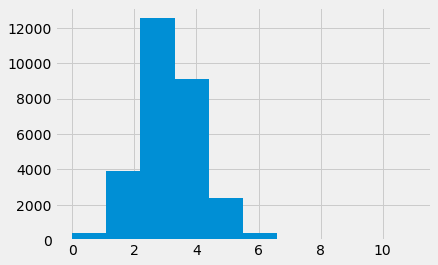

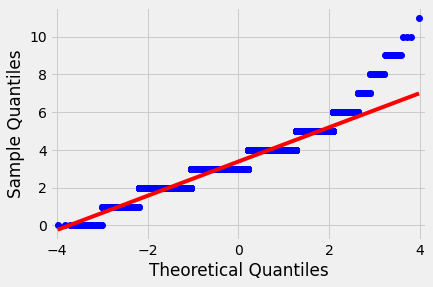

In [893]:
df['bedrooms'].hist();
sm.qqplot(df['bedrooms'], line='r');

In [894]:
X_NEW = df[['sqft_living_sqrt','grade', 'bedrooms']]
y = df['price_sqrt']

NEW_model = sm.OLS(y, sm.add_constant(X_NEW))
NEW_results = NEW_model.fit()
print(NEW_results.summary())

                            OLS Regression Results                            
Dep. Variable:             price_sqrt   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     6572.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:04:24   Log-Likelihood:            -1.9168e+05
No. Observations:               28897   AIC:                         3.834e+05
Df Residuals:                   28893   BIC:                         3.834e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -25.8153      8.120  

Once again, bedrooms as an added variable does not improve the rsquared in the model, so it will be left out. This ends our exploration of the numerical variables!

## Attempting interactions to improve model

In [895]:
df.corr()['price_sqrt'].abs().sort_values(ascending=False)

price_sqrt          1.000000
price               0.987192
sqft_living         0.591597
sqft_living_sqrt    0.586722
grade               0.574675
sqft_living_log     0.567022
sqft_above          0.505529
sqft_above_log      0.490600
bathrooms           0.465479
bedrooms            0.332801
sqft_patio          0.262311
sqft_garage         0.254652
sqft_basement       0.216284
floors              0.216042
view                0.207571
yr_built            0.096788
sale_year           0.095845
sale_date           0.087454
lat                 0.079176
sqft_lot            0.075319
sale_month          0.074205
yr_renovated        0.060367
waterfront          0.037779
condition           0.028102
long                0.022053
id                  0.008427
Name: price_sqrt, dtype: float64

- This interaction creates an almost perfectly linear plot. 

# Adding in Categorical variables

In [896]:
df.columns

Index(['id', 'sale_date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'sale_month', 'sale_year',
       'city', 'zipcode', 'City', 'price_sqrt', 'sqft_living_log',
       'sqft_living_sqrt', 'sqft_above_log'],
      dtype='object')

## Getting categorical candidates

In [897]:
categorical_candidates = df[['sale_date','bathrooms','bedrooms','floors','waterfront','greenbelt',\
                             'nuisance','view','condition','grade','heat_source','sewer_system',\
                             'yr_renovated','address','lat','long','City']]

In [898]:
categorical_candidates_price = pd.concat([categorical_candidates, df['price_sqrt']], axis='columns')

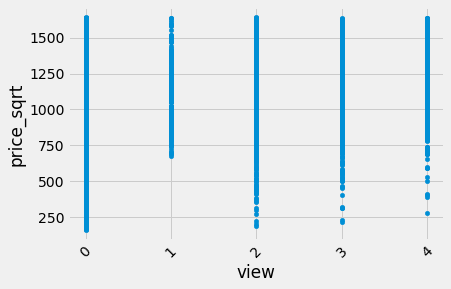

In [899]:

categorical_candidates_price.plot.scatter(x='view',y='price_sqrt')
plt.xticks(rotation=45)
plt.show()

In [900]:
df_.columns

Index(['sqft_living_sqrt', 'grade', 'view', 'bathrooms', 'waterfront'], dtype='object')

In [901]:
X_final = df[['sqft_living_sqrt','grade']]
y = df['price_sqrt']

final_model = sm.OLS(y, sm.add_constant(X_final))
final_results = final_model.fit()
print(final_results.summary())

                            OLS Regression Results                            
Dep. Variable:             price_sqrt   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     9824.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:04:31   Log-Likelihood:            -1.9170e+05
No. Observations:               28897   AIC:                         3.834e+05
Df Residuals:                   28894   BIC:                         3.834e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -36.1378      7.965  

In [902]:
final_resid = final_results.resid

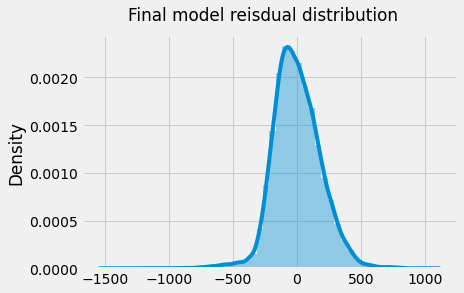

In [903]:
sns.distplot(final_resid)
plt.suptitle("Final model reisdual distribution")
plt.show()


In [904]:
r_squared_increase = str(round((final_results.rsquared - NEW_results.rsquared) * 100, 1)) + '%'
r_squared_increase

'-0.1%'

- Final model explains approximately 47.9% of the data according the the adjusted r-squared statistic.
- sqft_living_log is a statistically significant variable as it shows a p-value under the 0.05 parameter
- grade is a statistically significant variable as it shows a p-value under the 0.05 parameter
- view_EXCELLENT is a statistically significant variable as it shows a p-value under the 0.05 parameter
- view_FAIR is a statistically significant variable as it shows a p-value under the 0.05 parameter
- view_GOOD is a statistically significant variable as it shows a p-value under the 0.05 parameter
- view_AVERAGE is a statistically significant variable as it shows a p-value under the 0.05 parameter
- Addition of the grade as an independent variable increased the model adj. r-squared by 3.8%

In [934]:
dummies = pd.get_dummies(df['sale_month','sale_date','waterfront','condition',], drop_first=True)

KeyError: ('sale_month', 'sale_date', 'waterfront', 'condition')

In [935]:
water_front = df['waterfront']
lat = df['lat']
long = df['long']
view = df['view']


bathrooms = df['bathrooms']
X_final_zipcodes = pd.concat([dummies,X_final,water_front,lat,long, view,condition, sale_date,bathrooms],axis='columns')
X_final_zipcodes = (X_final_zipcodes - np.mean(X_final_zipcodes)) / np.std(X_final_zipcodes)

In [936]:

y = df['price_sqrt']

final_model = sm.OLS(y, sm.add_constant(X_final_zipcodes))
final_results = final_model.fit()
print(final_results.summary())

MissingDataError: exog contains inf or nans